In [1]:

!pip install tqdm

# 2. Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

from PIL import Image
from sklearn.model_selection import train_test_split


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

MONT_PATH = "/content/drive/MyDrive/DataSet/MontgomerySet/CXR_png"
SHENZHEN_PATH = "/content/drive/MyDrive/DataSet/ChinaSet_AllFiles/CXR_png"
TBX11K_PATH = "/content/drive/MyDrive/DataSet/TBnNormal"

In [5]:
from pathlib import Path
import os
from PIL import Image

def prepare_dataset():
    MONT_PATH = "/content/drive/MyDrive/DataSet/MontgomerySet/CXR_png"
    SHENZHEN_PATH = "/content/drive/MyDrive/DataSet/ChinaSet_AllFiles/CXR_png"
    TBX11K_PATH = "/content/drive/MyDrive/TB_Dataset/TBnNormal"

    OUTPUT_PATH = "/content/filtered_dataset"
    TB_DIR = os.path.join(OUTPUT_PATH, "TB")
    NORMAL_DIR = os.path.join(OUTPUT_PATH, "Normal")
    os.makedirs(TB_DIR, exist_ok=True)
    os.makedirs(NORMAL_DIR, exist_ok=True)

    def copy_resize(img_path, label, count):
        target_dir = TB_DIR if label == "TB" else NORMAL_DIR
        try:
            img = Image.open(img_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((224, 224))
            img.save(os.path.join(target_dir, f"{label}_{count}.jpg"), format='JPEG')
        except Exception as e:
            print(f"Skipped {img_path}: {e}")

    image_records = []

    # Montgomery
    for img in Path(MONT_PATH).rglob("*.png"):
        name = img.name
        if "_0.png" in name:
            label = "Normal"
        elif "_1.png" in name:
            label = "TB"
        else:
            continue
        image_records.append((img, label))

    # Shenzhen
    for img in Path(SHENZHEN_PATH).rglob("*.png"):
        name = img.name
        if "_0.png" in name:
            label = "Normal"
        elif "_1.png" in name:
            label = "TB"
        else:
            continue
        image_records.append((img, label))

    # TBX11K
    tbx_tb_path = os.path.join(TBX11K_PATH, "PULMONARY_TUBERCULOSIS")
    tbx_normal_path = os.path.join(TBX11K_PATH, "NORMAL")
    for img in Path(tbx_tb_path).rglob("*.jpg"):
        image_records.append((img, "TB"))
    for img in Path(tbx_normal_path).rglob("*.jpg"):
        image_records.append((img, "Normal"))

    for count, (img_path, label) in enumerate(image_records):
        copy_resize(img_path, label, count)


prepare_dataset()


In [6]:
# 4. Build Dataset & Dataloaders
DATA = "/content/filtered_dataset"
normals = list(Path(DATA,"Normal").rglob("*.jpg"))
tbs     = list(Path(DATA,"TB").rglob("*.jpg"))
imgs  = normals + tbs
lbls  = [0]*len(normals) + [1]*len(tbs)

tr_i, va_i, tr_l, va_l = train_test_split(
    imgs, lbls, test_size=0.2, random_state=42, stratify=lbls
)

class CXRDataset(Dataset):
    def __init__(self, imgs, labels, tfm):
        self.imgs=imgs; self.lbls=labels; self.tfm=tfm
    def __len__(self): return len(self.imgs)
    def __getitem__(self,i):
        img=Image.open(self.imgs[i])
        lbl=self.lbls[i]
        if self.tfm: img=self.tfm(img)
        return img, lbl

tfm = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
train_ds = CXRDataset(tr_i,tr_l,tfm)
val_ds   = CXRDataset(va_i,va_l,tfm)
train_loader = DataLoader(train_ds,batch_size=16,shuffle=True,num_workers=2)
val_loader   = DataLoader(val_ds,  batch_size=16,shuffle=False,num_workers=2)

In [7]:
# 5. CBAMWDNet
class CBAM(nn.Module):
    def __init__(self,ch,reduction=16,k=7):
        super().__init__()
        self.avg=nn.AdaptiveAvgPool2d(1)
        self.max=nn.AdaptiveMaxPool2d(1)
        self.fc=nn.Sequential(
            nn.Conv2d(ch,ch//reduction,1,bias=False),
            nn.ReLU(), nn.Conv2d(ch//reduction,ch,1,bias=False)
        )
        self.sig=nn.Sigmoid()
        self.spat=nn.Sequential(
            nn.Conv2d(2,1,k,padding=k//2,bias=False), nn.Sigmoid()
        )
    def forward(self,x):
        ca = self.sig(self.fc(self.avg(x))+self.fc(self.max(x)))
        x = x*ca
        avgc=x.mean(1,keepdim=True); maxc,_=x.max(1,keepdim=True)
        x = x*self.spat(torch.cat([avgc,maxc],1))
        return x

class DenseBlock(nn.Module):
    def __init__(self,in_ch,grow,n):
        super().__init__()
        layers=[]
        for i in range(n):
            layers.append(self._layer(in_ch+i*grow,grow))
        self.net=nn.Sequential(*layers)
    def _layer(self,ic,gr):
        return nn.Sequential(
            nn.BatchNorm2d(ic), nn.ReLU(inplace=True),
            nn.Conv2d(ic,gr,3,padding=1,bias=False),
            CBAM(gr)
        )
    def forward(self,x):
        for l in self.net:
            nf=l(x); x=torch.cat([x,nf],1)
        return x

class Transition(nn.Module):
    def __init__(self,ic,oc):
        super().__init__()
        self.net=nn.Sequential(
            nn.BatchNorm2d(ic), nn.ReLU(inplace=True),
            nn.Conv2d(ic,oc,1,bias=False), nn.AvgPool2d(2)
        )
    def forward(self,x): return self.net(x)

class CBAMWDNet(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        gr=32
        self.conv1=nn.Conv2d(3,64,7,2,3,bias=False)
        self.pool1=nn.MaxPool2d(3,2,1)
        self.b1=DenseBlock(64,gr,2); self.t1=Transition(64+2*gr,128)
        self.b2=DenseBlock(128,gr,2); self.t2=Transition(128+2*gr,256)
        self.b3=DenseBlock(256,gr,2); self.t3=Transition(256+2*gr,512)
        self.b4=DenseBlock(512,gr,2)
        self.conv2=nn.Conv2d(512+2*gr,512,7)
        self.fc=nn.Linear(512,num_classes)
    def forward(self,x):
        x=self.pool1(self.conv1(x))
        x=self.t1(self.b1(x)); x=self.t2(self.b2(x))
        x=self.t3(self.b3(x)); x=self.b4(x)
        x=self.conv2(x); x=x.view(x.size(0),-1)
        return self.fc(x)

In [8]:
# 7.

def get_model(name):
    if name == "CBAMWDNet":
        return CBAMWDNet()
    elif name == "ResNet50":
        m = models.resnet50(pretrained=False)
        m.fc = nn.Linear(m.fc.in_features, 2)
        return m
    elif name == "DenseNet121":
        m = models.densenet121(pretrained=False)
        m.classifier = nn.Linear(m.classifier.in_features, 2)
        return m
    elif name == "VGG16":
        m = models.vgg16(pretrained=False)
        m.classifier[6] = nn.Linear(4096, 2)
        return m
    else:
        raise ValueError

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Training and Evaluation
def train_and_eval(model_name, epochs=10):
    mdl = get_model(model_name).to(device)
    crit = nn.CrossEntropyLoss()
    opt = optim.SGD(mdl.parameters(), lr=0.001, momentum=0.9)
    sched = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        mdl.train()
        train_corrects = 0
        train_samples = 0

        for x, y in tqdm(train_loader, desc=f"{model_name} Train Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = mdl(x)
            loss = crit(out, y)
            loss.backward()
            opt.step()

            _, preds = torch.max(out, 1)
            train_corrects += torch.sum(preds == y).item()
            train_samples += y.size(0)

        train_acc = train_corrects / train_samples
        train_acc_list.append(train_acc)
        sched.step()

        mdl.eval()
        val_corrects = 0
        val_samples = 0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"{model_name} Val Epoch {epoch+1}/{epochs}"):
                x, y = x.to(device), y.to(device)
                out = mdl(x)
                _, preds = torch.max(out, 1)
                val_corrects += torch.sum(preds == y).item()
                val_samples += y.size(0)

        val_acc = val_corrects / val_samples
        val_acc_list.append(val_acc)

    # Final evaluation after training
    mdl.eval()
    yt, yp, ys = [], [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"{model_name} Final Eval"):
            x, y = x.to(device), y.to(device)
            out = mdl(x)
            prob = F.softmax(out, 1)
            _, preds = torch.max(prob, 1)
            yt.extend(y.cpu().numpy())
            yp.extend(preds.cpu().numpy())
            ys.extend(prob[:, 1].cpu().numpy())

    yt = np.array(yt)
    yp = np.array(yp)
    ys = np.array(ys)

    acc = accuracy_score(yt, yp)
    prec = precision_score(yt, yp)
    rec = recall_score(yt, yp)
    f1s = f1_score(yt, yp)
    tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
    spec = tn / (tn + fp)
    npv = tn / (tn + fn)
    auc = roc_auc_score(yt, ys)

    return {
        'Model': model_name,
        'Train Accuracy': train_acc_list,
        'Validation Accuracy': val_acc_list,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'Specificity': spec,
        'NPV': npv,
        'F1 Score': f1s,
        'AUC': auc,
        'yt': yt,
        'ys': ys
    }

Using device: cpu


In [9]:
# 8.Training + Evaluation for all models
import pandas as pd
results = []
for model_name in ["CBAMWDNet", "ResNet50", "DenseNet121", "VGG16"]:
    print(f"\n=== Training and Evaluating: {model_name} ===\n")
    result = train_and_eval(model_name, epochs=10)
    results.append(result)


=== Training and Evaluating: CBAMWDNet ===



CBAMWDNet Final Eval: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



=== Training and Evaluating: ResNet50 ===



ResNet50 Final Eval: 100%|██████████| 10/10 [00:31<00:00,  3.19s/it]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



=== Training and Evaluating: DenseNet121 ===



DenseNet121 Final Eval: 100%|██████████| 10/10 [00:28<00:00,  2.80s/it]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



=== Training and Evaluating: VGG16 ===



VGG16 Final Eval: 100%|██████████| 10/10 [01:49<00:00, 10.93s/it]



Model Comparison Table:

             Accuracy  Precision    Recall  Specificity       NPV  F1 Score  \
Model                                                                         
CBAMWDNet     0.76875   0.808824  0.696203     0.839506  0.739130  0.748299   
ResNet50      0.66250   0.681159  0.594937     0.728395  0.648352  0.635135   
DenseNet121   0.68125   0.705882  0.607595     0.753086  0.663043  0.653061   
VGG16         0.70000   0.686747  0.721519     0.679012  0.714286  0.703704   

                  AUC  
Model                  
CBAMWDNet    0.837943  
ResNet50     0.735896  
DenseNet121  0.771683  
VGG16        0.761682  


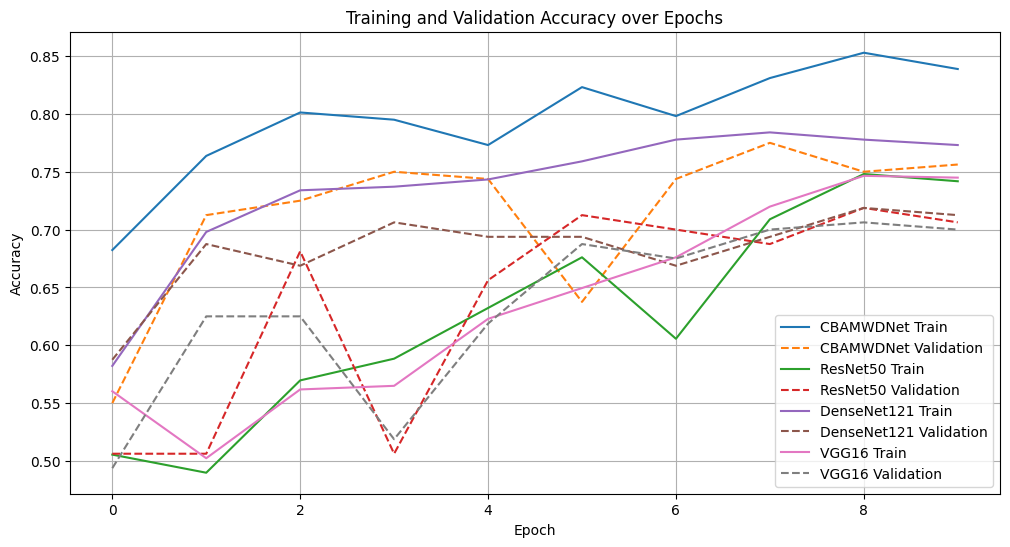

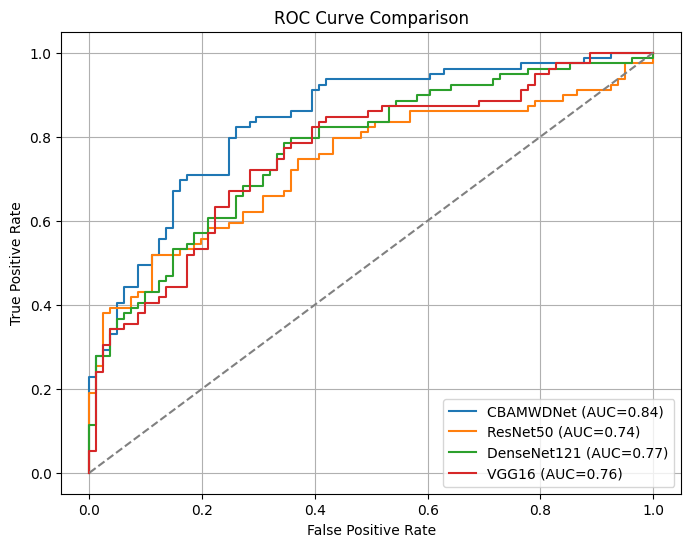

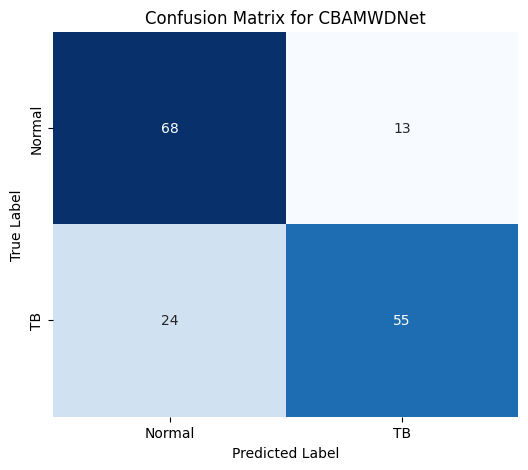

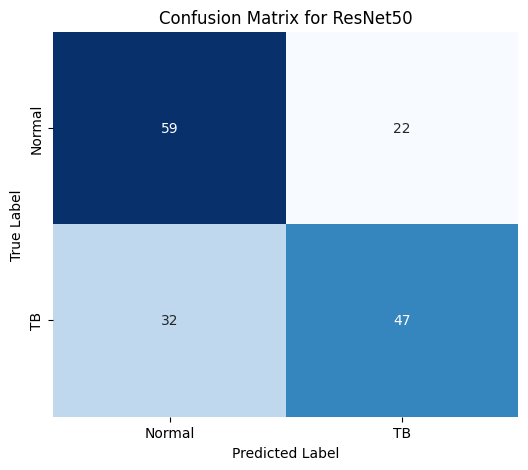

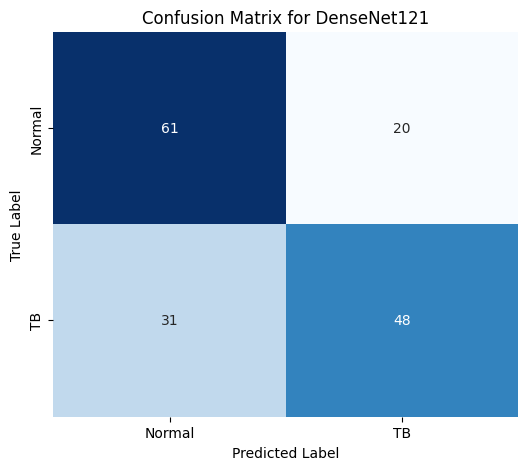

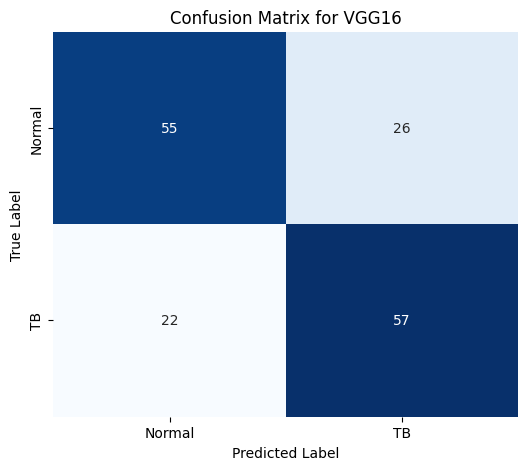

In [10]:
!pip install seaborn

import seaborn as sns

# 9. Create Summary Table
df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['yt', 'ys', 'Train Accuracy', 'Validation Accuracy']} for r in results])
print("\nModel Comparison Table:\n")
print(df.set_index("Model"))

# 10. Plot Train and Validation Accuracy for Each Model
plt.figure(figsize=(12, 6))
for r in results:
    plt.plot(r['Train Accuracy'], label=f'{r["Model"]} Train')
    plt.plot(r['Validation Accuracy'], linestyle='--', label=f'{r["Model"]} Validation')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 11. Plot ROC Curves
plt.figure(figsize=(8, 6))
for r in results:
    fpr, tpr, _ = roc_curve(r['yt'], r['ys'])
    plt.plot(fpr, tpr, label=f'{r["Model"]} (AUC={r["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# 12. Plot Confusion Matrix Heatmaps
for r in results:
    cm = confusion_matrix(r['yt'], (r['ys'] > 0.5).astype(int))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Normal", "TB"], yticklabels=["Normal", "TB"])
    plt.title(f'Confusion Matrix for {r["Model"]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Model Comparison Table:

             Accuracy  Precision    Recall  Specificity       NPV  F1 Score  \
Model                                                                         
CBAMWDNet     0.76875   0.808824  0.696203     0.839506  0.739130  0.748299   
ResNet50      0.66250   0.681159  0.594937     0.728395  0.648352  0.635135   
DenseNet121   0.68125   0.705882  0.607595     0.753086  0.663043  0.653061   
VGG16         0.70000   0.686747  0.721519     0.679012  0.714286  0.703704   

                  AUC  
Model                  
CBAMWDNet    0.837943  
ResNet50     0.735896  
DenseNet121  0.771683  
VGG16        0.761682  


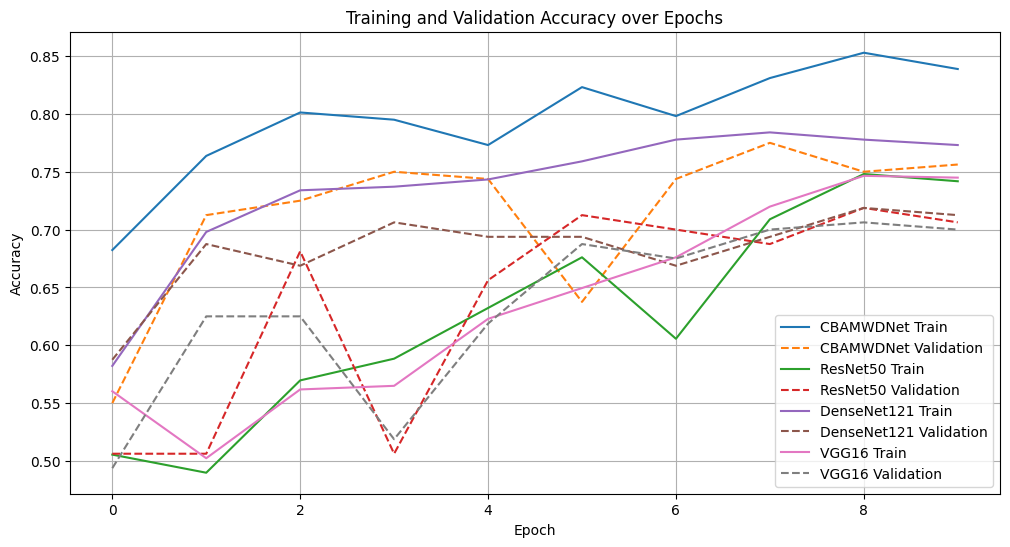

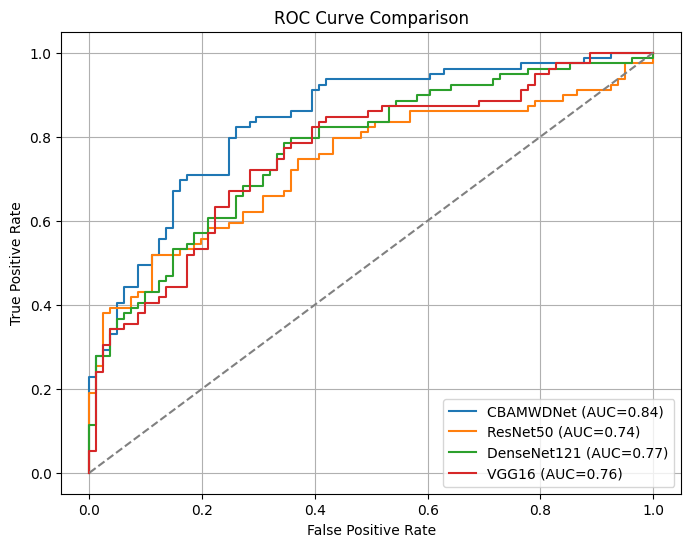

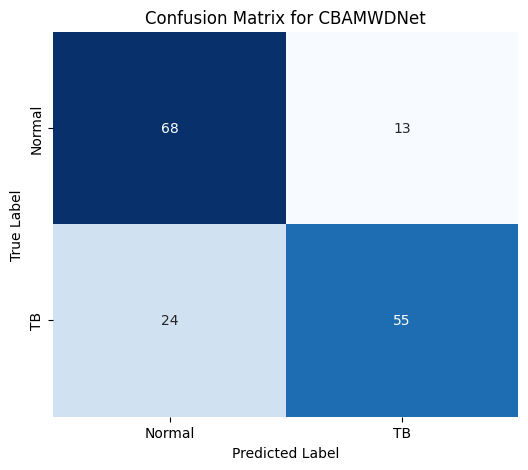

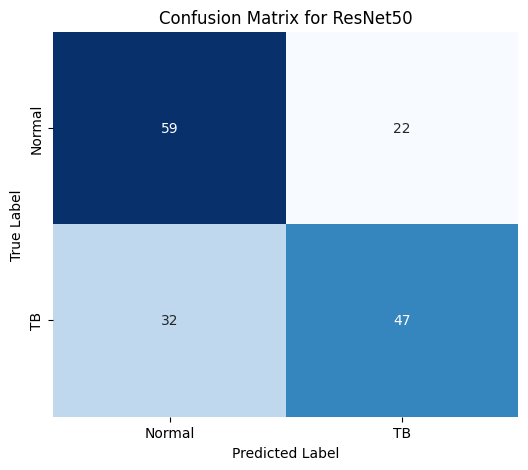

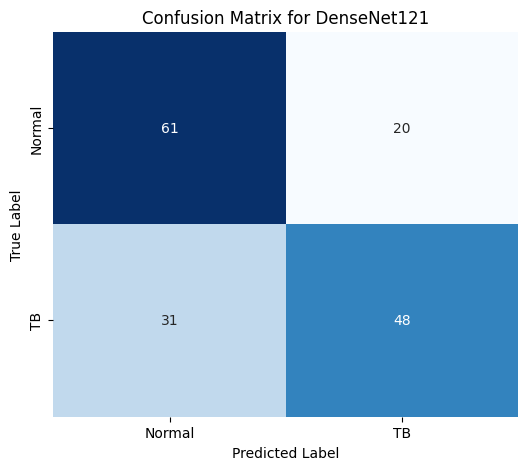

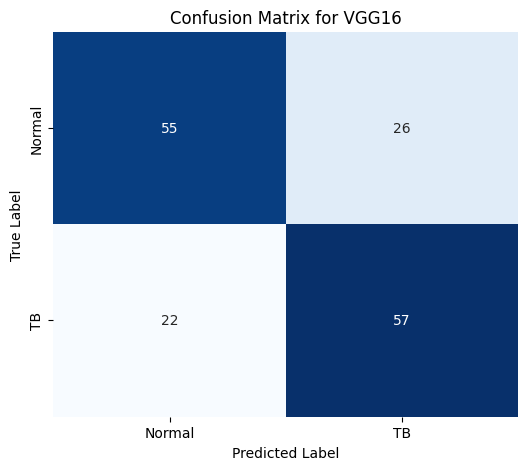

In [11]:
import pandas as pd
!pip install seaborn   # install seaborn (only once)

import seaborn as sns
# 9. Create Summary Table
df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['yt', 'ys', 'Train Accuracy', 'Validation Accuracy']} for r in results])
print("\nModel Comparison Table:\n")
print(df.set_index("Model"))

# 10. Plot Train and Validation Accuracy for Each Model
plt.figure(figsize=(12, 6))
for r in results:
    plt.plot(r['Train Accuracy'], label=f'{r["Model"]} Train')
    plt.plot(r['Validation Accuracy'], linestyle='--', label=f'{r["Model"]} Validation')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 11. Plot ROC Curves
plt.figure(figsize=(8, 6))
for r in results:
    fpr, tpr, _ = roc_curve(r['yt'], r['ys'])
    plt.plot(fpr, tpr, label=f'{r["Model"]} (AUC={r["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

# 12. Plot Confusion Matrix Heatmaps
for r in results:
    cm = confusion_matrix(r['yt'], (r['ys'] > 0.5).astype(int))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Normal", "TB"], yticklabels=["Normal", "TB"])
    plt.title(f'Confusion Matrix for {r["Model"]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [12]:
# 9. Summary table
df=pd.DataFrame([{k:v for k,v in r.items() if k!="yt" and k!="ys"} for r in results])
print("\nComparison:\n",df.set_index("Model"))


Comparison:
                                                 Train Accuracy  \
Model                                                            
CBAMWDNet    [0.6823161189358372, 0.7636932707355243, 0.801...   
ResNet50     [0.5054773082942097, 0.48982785602503914, 0.56...   
DenseNet121  [0.5821596244131455, 0.6979655712050078, 0.733...   
VGG16        [0.5602503912363067, 0.5023474178403756, 0.561...   

                                           Validation Accuracy  Accuracy  \
Model                                                                      
CBAMWDNet    [0.55, 0.7125, 0.725, 0.75, 0.74375, 0.6375, 0...   0.76875   
ResNet50     [0.50625, 0.50625, 0.68125, 0.50625, 0.65625, ...   0.66250   
DenseNet121  [0.5875, 0.6875, 0.66875, 0.70625, 0.69375, 0....   0.68125   
VGG16        [0.49375, 0.625, 0.625, 0.51875, 0.61875, 0.68...   0.70000   

             Precision    Recall  Specificity       NPV  F1 Score       AUC  
Model                                                 

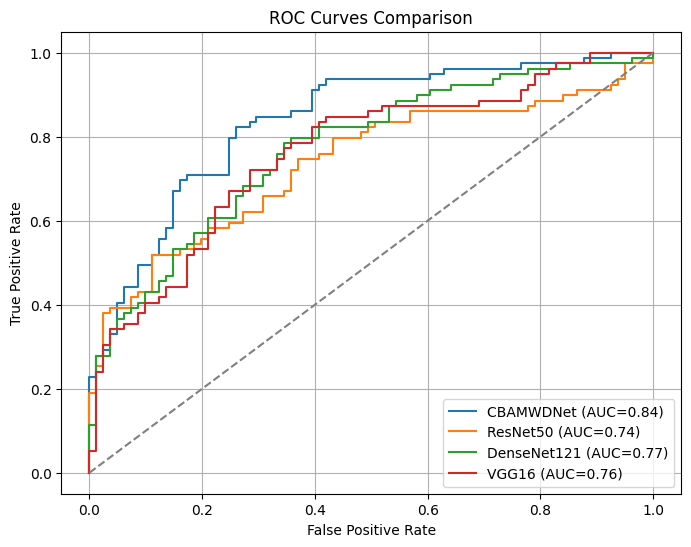

In [13]:
# 10. Plot ROC curves
plt.figure(figsize=(8,6))
for r in results:
    fpr,tpr,_=roc_curve(r["yt"],r["ys"])
    plt.plot(fpr,tpr,label=f"{r['Model']} (AUC={r['AUC']:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison"); plt.legend(); plt.grid(); plt.show()